Model şu cihazda çalışacak: cuda
Sınıf dağılımı:
Duygu Etiketi
negative    3026
positive    2854
Name: count, dtype: int64


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,No log,0.626785,0.634354,0.697619,0.491611,0.781034,0.576772,0.636323
2,0.651300,0.548530,0.720238,0.758221,0.657718,0.784483,0.704403,0.721100
3,0.651300,0.441639,0.801020,0.816434,0.783557,0.818966,0.799658,0.801261
4,0.468600,0.446352,0.829082,0.854578,0.798658,0.860345,0.825672,0.829501
5,0.468600,0.487585,0.825680,0.840000,0.810403,0.841379,0.824936,0.825891


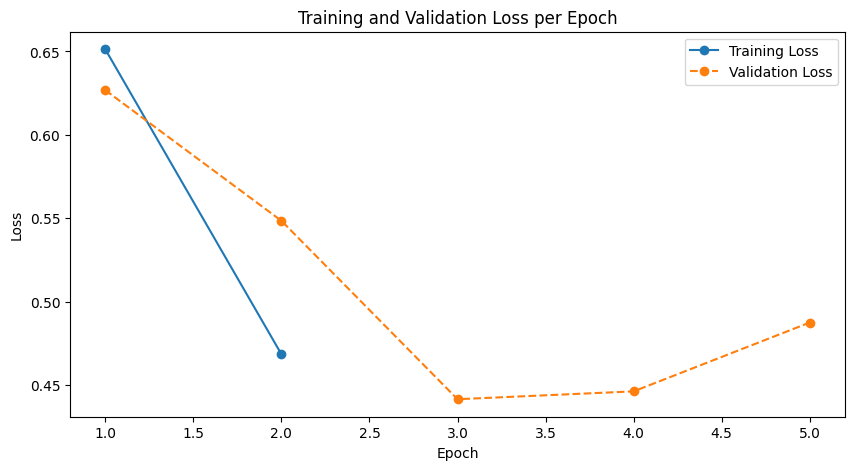

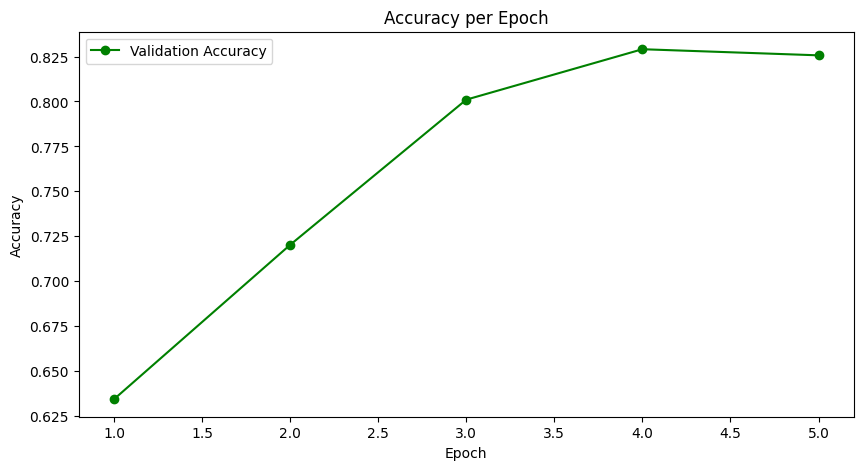

In [ ]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay, recall_score,
)
from datasets import Dataset
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. GPU kullanılabilirliğini kontrol et
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model şu cihazda çalışacak: {device}")

# 2. Veriyi yükle
file_path = "All_Scrapping_Corrected_Sentiment_Labels.csv"
data = pd.read_csv(file_path)

# Veri seti hakkında bilgi
print("Sınıf dağılımı:")
print(data['Duygu Etiketi'].value_counts())

# 3. Eğitim ve test setlerini oluştur
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Yorum Temiz'].tolist(),
    data['Duygu Etiketi'].map({'positive': 1, 'negative': 0}).tolist(),
    test_size=0.2,
    random_state=42
)

# 4. Tokenizer ile veri hazırlama
model_name = "distilgpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Pad token ekleme
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512)

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

# 5. Dataset oluşturma
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

# 6. Modeli tanımla ve GPU'ya taşı
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

# 7. Eğitim ayarlarını yap
training_args = TrainingArguments(
    output_dir="./results_distilgpt2",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs_distilgpt2",
    eval_strategy="epoch",
    fp16=True if torch.cuda.is_available() else False,
)

# 8. Performans metriklerini hesaplama fonksiyonu
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds) if len(set(labels)) > 1 else 0.5
    specificity = recall_score(labels, preds, pos_label=0)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1": f1,
        "auc": auc,
    }

# 9. Modeli eğit ve değerlendir
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

# 10. Eğitim sırasında kaydedilen metrikleri alın
metrics = trainer.state.log_history

# Training ve Validation Loss
training_loss = [m.get("loss", None) for m in metrics if "loss" in m]
validation_loss = [m.get("eval_loss", None) for m in metrics if "eval_loss" in m]

# Epoch sayısını belirleyin
epochs_training = range(1, len(training_loss) + 1)
epochs_validation = range(1, len(validation_loss) + 1)

# Loss Grafiği
plt.figure(figsize=(10, 5))
plt.plot(epochs_training, training_loss, label="Training Loss", marker='o')
plt.plot(epochs_validation, validation_loss, label="Validation Loss", marker='o', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.savefig("loss_per_epoch_distilgpt2.png")
plt.show()

# Accuracy Grafiği
accuracy = [m.get("eval_accuracy", None) for m in metrics if "eval_accuracy" in m]
valid_epochs = range(1, len(accuracy) + 1)
valid_accuracy = [acc for acc in accuracy if acc is not None]

plt.figure(figsize=(10, 5))
plt.plot(valid_epochs, valid_accuracy, label="Validation Accuracy", color="green", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.savefig("accuracy_per_epoch_distilgpt2.png")
plt.show()

# Confusion Matrix
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_distilgpt2.png")
plt.show()

# Performans sonuçlarını kaydet
print("Performans:", predictions.metrics)
results_df = pd.DataFrame(predictions.metrics, index=[0])
results_df.to_csv("distilgpt2_model_results.csv", index=False)
